In [1]:
# import sys 
# sys.path
# sys.path.append("~/anaconda3/lib/python3.8/site-packages/tensorflow_estimator")
# sys.path
# import tensorflow as tf
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config inlinebackend.figure_format = 'retina'
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from sklearn.metrics import accuracy_score
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1，2'

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1，2"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 64
        self.data_dir = '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/data/SHREC/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=3,feat_d=231,filters=64):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=64):
    M = Input(name='M', shape=(frame_l,feat_d))   #32,231
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) #32,22,3
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters) #32,22,3,231,16
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters) #32,22,3,231,14,64

In [7]:
DD_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 231)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 22, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1740160     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]              

## load data

In [8]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [9]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1  

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  #(1960,32,231) ndarray
X_1 = np.stack(X_1)  #(1960,32,22,3)
Y = np.stack(Y)

100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 113.33it/s]


In [10]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████| 840/840 [00:07<00:00, 115.11it/s]


In [11]:
# it may takes several times to reach the reported performance

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y, 
            batch_size=len(Y),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 8s 4ms/step - loss: 3.3907 - accuracy: 0.0689 - val_loss: 2.6384 - val_accuracy: 0.0798
Epoch 2/600
1960/1960 [==============================] - 0s 145us/step - loss: 2.8514 - accuracy: 0.1372 - val_loss: 2.6386 - val_accuracy: 0.0774
Epoch 3/600
1960/1960 [==============================] - 0s 140us/step - loss: 2.5575 - accuracy: 0.1913 - val_loss: 2.6390 - val_accuracy: 0.0607
Epoch 4/600
1960/1960 [==============================] - 0s 132us/step - loss: 2.3189 - accuracy: 0.2480 - val_loss: 2.6395 - val_accuracy: 0.0607
Epoch 5/600
1960/1960 [==============================] - 0s 142us/step - loss: 2.1717 - accuracy: 0.2939 - val_loss: 2.6403 - val_accuracy: 0.0619
Epoch 6/600
1960/1960 [==============================] - 0s 133us/step - loss: 2.0176 - accuracy: 0.3541 - val_loss: 2.6412 - val_accuracy: 0.0738
Epoch 7/600
1960/1960 [==============================] - 0s 141us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 147us/step - loss: 0.1406 - accuracy: 0.9816 - val_loss: 3.1890 - val_accuracy: 0.0845
Epoch 58/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.1336 - accuracy: 0.9806 - val_loss: 3.2234 - val_accuracy: 0.0798
Epoch 59/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.1384 - accuracy: 0.9796 - val_loss: 3.2627 - val_accuracy: 0.0786
Epoch 60/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.1219 - accuracy: 0.9842 - val_loss: 3.2891 - val_accuracy: 0.0786
Epoch 61/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.1297 - accuracy: 0.9827 - val_loss: 3.3134 - val_accuracy: 0.0774
Epoch 62/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.1254 - accuracy: 0.9801 - val_loss: 3.3310 - val_accuracy: 0.0774
Epoch 63/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.1203 - accuracy: 0.9791 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0487 - accuracy: 0.9944 - val_loss: 3.6115 - val_accuracy: 0.0607
Epoch 114/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0406 - accuracy: 0.9964 - val_loss: 3.6017 - val_accuracy: 0.0607
Epoch 115/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0453 - accuracy: 0.9954 - val_loss: 3.5878 - val_accuracy: 0.0607
Epoch 116/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0415 - accuracy: 0.9969 - val_loss: 3.5649 - val_accuracy: 0.0607
Epoch 117/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0421 - accuracy: 0.9969 - val_loss: 3.5396 - val_accuracy: 0.0607
Epoch 118/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0432 - accuracy: 0.9944 - val_loss: 3.5145 - val_accuracy: 0.0607
Epoch 119/600
1960/1960 [==============================] - 0s 150us/step - loss: 0.0434 - accuracy: 0.9954

Epoch 168/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0404 - accuracy: 0.9969 - val_loss: 3.6279 - val_accuracy: 0.0762
Epoch 169/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0390 - accuracy: 0.9964 - val_loss: 3.6206 - val_accuracy: 0.0762
Epoch 170/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0434 - accuracy: 0.9959 - val_loss: 3.6136 - val_accuracy: 0.0762
Epoch 171/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0441 - accuracy: 0.9939 - val_loss: 3.6078 - val_accuracy: 0.0762
Epoch 172/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0403 - accuracy: 0.9954 - val_loss: 3.6025 - val_accuracy: 0.0786
Epoch 173/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0402 - accuracy: 0.9964 - val_loss: 3.5980 - val_accuracy: 0.0786
Epoch 174/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0405 - accuracy: 0.9954

Epoch 223/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0348 - accuracy: 0.9980 - val_loss: 3.2203 - val_accuracy: 0.1524
Epoch 224/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0404 - accuracy: 0.9974 - val_loss: 3.2101 - val_accuracy: 0.1536
Epoch 225/600
1960/1960 [==============================] - 0s 147us/step - loss: 0.0398 - accuracy: 0.9964 - val_loss: 3.1995 - val_accuracy: 0.1536
Epoch 226/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0436 - accuracy: 0.9964 - val_loss: 3.1895 - val_accuracy: 0.1548
Epoch 227/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0413 - accuracy: 0.9954 - val_loss: 3.1797 - val_accuracy: 0.1560
Epoch 228/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0425 - accuracy: 0.9954 - val_loss: 3.1689 - val_accuracy: 0.1571
Epoch 229/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0376 - accuracy: 0.9980

Epoch 278/600
1960/1960 [==============================] - 0s 149us/step - loss: 0.0364 - accuracy: 0.9964 - val_loss: 2.5743 - val_accuracy: 0.3048
Epoch 279/600
1960/1960 [==============================] - 0s 153us/step - loss: 0.0404 - accuracy: 0.9959 - val_loss: 2.5614 - val_accuracy: 0.3083
Epoch 280/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0394 - accuracy: 0.9969 - val_loss: 2.5488 - val_accuracy: 0.3131
Epoch 281/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0411 - accuracy: 0.9944 - val_loss: 2.5355 - val_accuracy: 0.3131
Epoch 282/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0426 - accuracy: 0.9964 - val_loss: 2.5221 - val_accuracy: 0.3131
Epoch 283/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0407 - accuracy: 0.9980 - val_loss: 2.5085 - val_accuracy: 0.3167
Epoch 284/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0361 - accuracy: 0.9980

Epoch 333/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0359 - accuracy: 0.9974 - val_loss: 1.8669 - val_accuracy: 0.4821
Epoch 334/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0428 - accuracy: 0.9964 - val_loss: 1.8548 - val_accuracy: 0.4893
Epoch 335/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0445 - accuracy: 0.9964 - val_loss: 1.8425 - val_accuracy: 0.4964
Epoch 336/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0403 - accuracy: 0.9954 - val_loss: 1.8301 - val_accuracy: 0.5024
Epoch 337/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0375 - accuracy: 0.9964 - val_loss: 1.8182 - val_accuracy: 0.5071
Epoch 338/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0386 - accuracy: 0.9964 - val_loss: 1.8060 - val_accuracy: 0.5107
Epoch 339/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0396 - accuracy: 0.9974

Epoch 388/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0403 - accuracy: 0.9949 - val_loss: 1.2263 - val_accuracy: 0.6655
Epoch 389/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0387 - accuracy: 0.9974 - val_loss: 1.2161 - val_accuracy: 0.6690
Epoch 390/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0401 - accuracy: 0.9959 - val_loss: 1.2054 - val_accuracy: 0.6702
Epoch 391/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0393 - accuracy: 0.9964 - val_loss: 1.1949 - val_accuracy: 0.6750
Epoch 392/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0386 - accuracy: 0.9969 - val_loss: 1.1848 - val_accuracy: 0.6786
Epoch 393/600
1960/1960 [==============================] - 0s 155us/step - loss: 0.0444 - accuracy: 0.9949 - val_loss: 1.1744 - val_accuracy: 0.6798
Epoch 394/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0375 - accuracy: 0.9964

Epoch 443/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0444 - accuracy: 0.9949 - val_loss: 0.7419 - val_accuracy: 0.7893
Epoch 444/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0421 - accuracy: 0.9969 - val_loss: 0.7345 - val_accuracy: 0.7893
Epoch 445/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0432 - accuracy: 0.9954 - val_loss: 0.7271 - val_accuracy: 0.7917
Epoch 446/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0381 - accuracy: 0.9974 - val_loss: 0.7197 - val_accuracy: 0.7940
Epoch 447/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0370 - accuracy: 0.9985 - val_loss: 0.7124 - val_accuracy: 0.7952
Epoch 448/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0384 - accuracy: 0.9985 - val_loss: 0.7048 - val_accuracy: 0.7988
Epoch 449/600
1960/1960 [==============================] - 0s 154us/step - loss: 0.0404 - accuracy: 0.9969

Epoch 498/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0353 - accuracy: 0.9964 - val_loss: 0.4348 - val_accuracy: 0.8810
Epoch 499/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0417 - accuracy: 0.9969 - val_loss: 0.4308 - val_accuracy: 0.8833
Epoch 500/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0363 - accuracy: 0.9980 - val_loss: 0.4268 - val_accuracy: 0.8857
Epoch 501/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0400 - accuracy: 0.9964 - val_loss: 0.4230 - val_accuracy: 0.8857
Epoch 502/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0389 - accuracy: 0.9980 - val_loss: 0.4191 - val_accuracy: 0.8869
Epoch 503/600
1960/1960 [==============================] - 0s 156us/step - loss: 0.0374 - accuracy: 0.9980 - val_loss: 0.4154 - val_accuracy: 0.8869
Epoch 504/600
1960/1960 [==============================] - 0s 149us/step - loss: 0.0369 - accuracy: 0.9980

Epoch 553/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0362 - accuracy: 0.9980 - val_loss: 0.2790 - val_accuracy: 0.9238
Epoch 554/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0352 - accuracy: 0.9985 - val_loss: 0.2770 - val_accuracy: 0.9250
Epoch 555/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0394 - accuracy: 0.9964 - val_loss: 0.2750 - val_accuracy: 0.9262
Epoch 556/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0369 - accuracy: 0.9964 - val_loss: 0.2731 - val_accuracy: 0.9262
Epoch 557/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0340 - accuracy: 0.9985 - val_loss: 0.2713 - val_accuracy: 0.9262
Epoch 558/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0358 - accuracy: 0.9980 - val_loss: 0.2694 - val_accuracy: 0.9262
Epoch 559/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0398 - accuracy: 0.9969

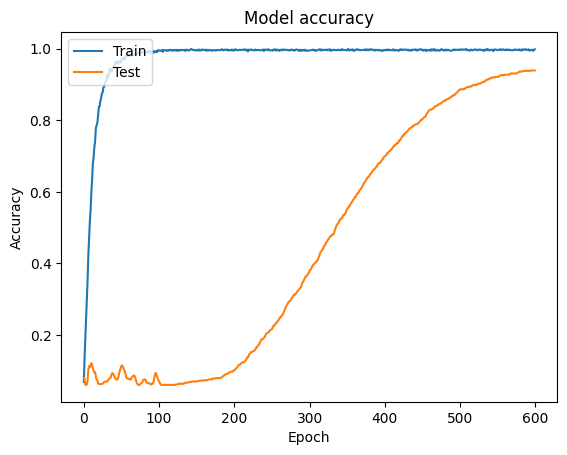

In [12]:
# Plot training & validation accuracy values
# plt.ylim(90,100)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/SHREC/images/DRLDDNet_14_test1.png")
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
# DD_Net.save_weights('weights/coarse_heavy.h1')

In [14]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [15]:
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [16]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9392857142857143


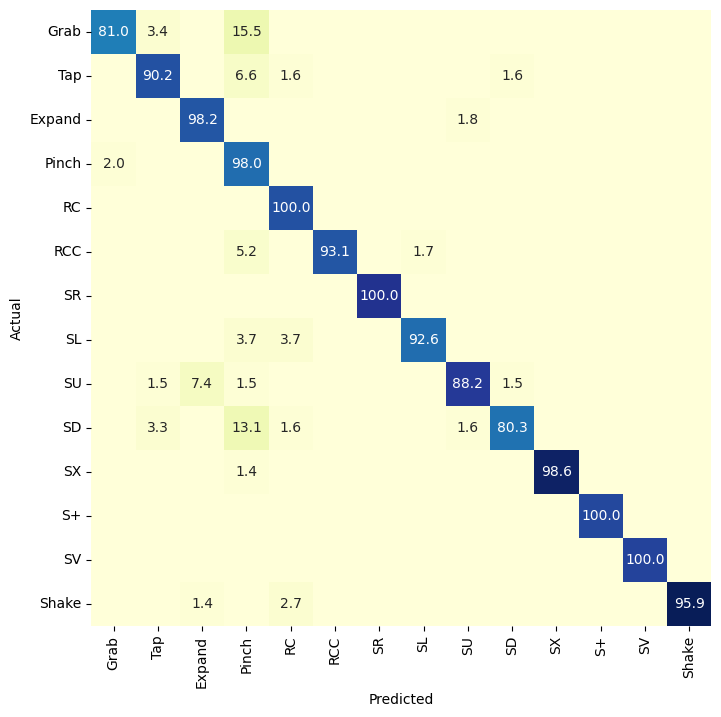

In [17]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_tes2.png', labels, ymap=None, figsize=(8,8))

## Training with frame_sampling

In [18]:
lr = 5e-6
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])

In [19]:
epochs = 20  #20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_coarse)
        label[Train['coarse_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
        
       
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net_model = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

epoch0


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 113.36it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0423 - accuracy: 0.9939 - val_loss: 0.2056 - val_accuracy: 0.9393
epoch1


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 111.42it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 109us/step - loss: 0.0440 - accuracy: 0.9944 - val_loss: 0.2041 - val_accuracy: 0.9393
epoch2


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 113.65it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 111us/step - loss: 0.0502 - accuracy: 0.9944 - val_loss: 0.2025 - val_accuracy: 0.9417
epoch3


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 113.08it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 107us/step - loss: 0.0482 - accuracy: 0.9949 - val_loss: 0.2013 - val_accuracy: 0.9417
epoch4


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 111.31it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 104us/step - loss: 0.0414 - accuracy: 0.9949 - val_loss: 0.2001 - val_accuracy: 0.9417
epoch5


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 112.88it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 111us/step - loss: 0.0378 - accuracy: 0.9980 - val_loss: 0.1991 - val_accuracy: 0.9417
epoch6


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 113.29it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 106us/step - loss: 0.0446 - accuracy: 0.9949 - val_loss: 0.1981 - val_accuracy: 0.9417
epoch7


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 112.56it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 107us/step - loss: 0.0415 - accuracy: 0.9964 - val_loss: 0.1970 - val_accuracy: 0.9417
epoch8


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 111.52it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 116us/step - loss: 0.0461 - accuracy: 0.9939 - val_loss: 0.1959 - val_accuracy: 0.9429
epoch9


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 110.78it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 106us/step - loss: 0.0530 - accuracy: 0.9923 - val_loss: 0.1950 - val_accuracy: 0.9429
epoch10


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 111.28it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 106us/step - loss: 0.0470 - accuracy: 0.9918 - val_loss: 0.1941 - val_accuracy: 0.9429
epoch11


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 111.12it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 104us/step - loss: 0.0436 - accuracy: 0.9959 - val_loss: 0.1932 - val_accuracy: 0.9429
epoch12


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 112.20it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 109us/step - loss: 0.0459 - accuracy: 0.9949 - val_loss: 0.1923 - val_accuracy: 0.9429
epoch13


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 112.76it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 107us/step - loss: 0.0435 - accuracy: 0.9939 - val_loss: 0.1916 - val_accuracy: 0.9417
epoch14


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 112.41it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 107us/step - loss: 0.0428 - accuracy: 0.9964 - val_loss: 0.1908 - val_accuracy: 0.9417
epoch15


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 113.96it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 105us/step - loss: 0.0435 - accuracy: 0.9964 - val_loss: 0.1900 - val_accuracy: 0.9405
epoch16


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 111.70it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 109us/step - loss: 0.0461 - accuracy: 0.9964 - val_loss: 0.1893 - val_accuracy: 0.9405
epoch17


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 111.41it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 111us/step - loss: 0.0479 - accuracy: 0.9944 - val_loss: 0.1886 - val_accuracy: 0.9405
epoch18


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 109.85it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 110us/step - loss: 0.0451 - accuracy: 0.9954 - val_loss: 0.1879 - val_accuracy: 0.9405
epoch19


100%|██████████████████████████████████████| 1960/1960 [00:17<00:00, 110.89it/s]


Train on 1960 samples, validate on 840 samples
Epoch 1/1
1960/1960 [==============================] - 0s 104us/step - loss: 0.0479 - accuracy: 0.9934 - val_loss: 0.1873 - val_accuracy: 0.9405


# Plotting confusion matrix

In [20]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [21]:
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [22]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9404761904761905


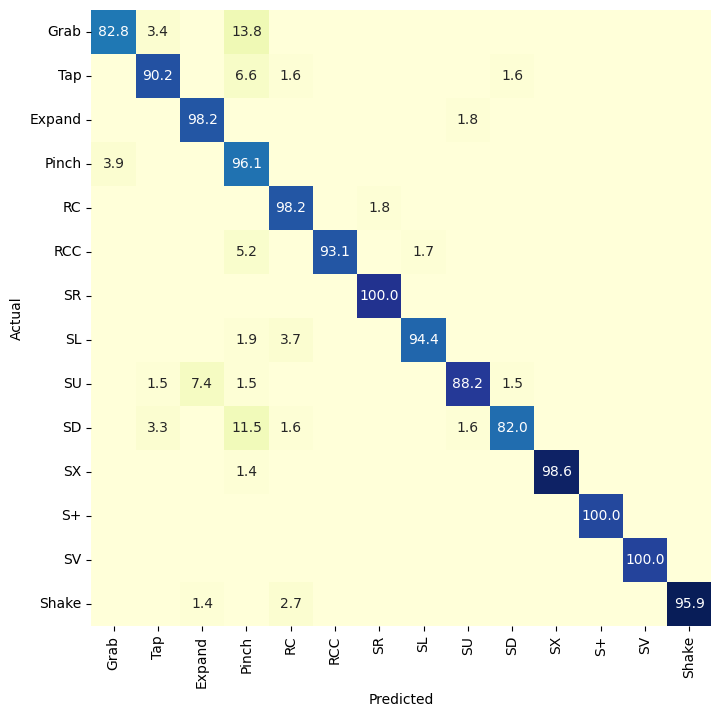

In [23]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_test3.png', labels, ymap=None, figsize=(8,8))

# Policy gradient for frame selection  -------train

In [24]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable  
from torch.nn import Linear,ReLU,CrossEntropyLoss,Sequential,Conv2d,MaxPool2d,Module,Softmax,BatchNorm2d,Dropout
from torch.optim import Adam,SGD

from numpy.random import default_rng
from utils import *

from numpy.random import default_rng


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


gamma = 0.7


class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions 

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),) 

        self.linear_layers = Sequential(
            Linear(8448,3)) #30 8448
#         optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x): 
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):  
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))   #
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy())) 
        log_pr = torch.log(pr.squeeze(0)[act]) 
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs): 
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r     
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class): 
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 5 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10
  
  
  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    true_class = int(true_class)
    reward = (np.sign(Probs[true_class - 1]  - Probs_history[true_class - 1])) ## -1 is bcz classes are from 1 to 10

  return reward   

def train(oridata,labels): 
    n_states=32 
    n_actions=3 
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128) 
    max_episode_num =  1  #10
    max_steps = 32  

    all_rewards = []

    label_new=[]
    final_ind=[]
    for episode in tqdm(range(max_episode_num)):        
        rewards2=[]
        x_tr=[]
        for v in tqdm(range(len(oridata))):
            log_probs = []
            rewards = []

            rng = default_rng()
            Action=[]
            if len(oridata[v])>=32:

                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=False))   
            else:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=True))  
            XX=oridata[v]  
            original_fr=XX.clone().detach()  
            original_label=labels[v].numpy()
            
            for steps in range(len(MM)):
                state = original_fr[MM[steps]]
                state = state.reshape(1, 1, 22, 3)
                state = torch.Tensor(state)
                action, log_prob = policy_net.select_action(state)
                Action.append(action)

                if action == 0 :
                    if steps == 0:
                        a = 0
                    else:
                        a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                    d = min(1, MM[steps] - a)
                    MM[steps] = MM[steps] - d
                if action == 1:
                    MM[steps] = MM[steps]
                if action == 2:
                    if steps == len(MM) - 1:
                        a = len(original_fr)
                    else:
                        a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                    d = min(1, a - MM[steps] - 1)
                    MM[steps] = MM[steps] + d

                xm1 = XX[MM]
                xmm = xm1
                q = np.array(xm1)
                q = zoom(q,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
                M = get_CG(q,C)  
                q = q.reshape(1,32,22,3)
                M = M.reshape(1,32,231)

                original_fr = XX
                output = DD_Net.predict([M,q])       
                prob = output
                prediction = np.argmax(output,axis=1)

                prob=prob[0]
                if (steps == 0):
                  reward = 1 if prediction==original_label else -1   
                else:
                  reward=calculate_reward(prob, Probs_history ,original_label)
                Probs_history=prob 
                log_probs.append(log_prob)
                rewards.append(reward)
            
                if steps==len(MM) - 1:
                    xm1_step = XX[MM]
            x_tr.append(xm1_step)
            rewards2.append(np.mean(rewards))
            update_policy(policy_net, rewards, log_probs)    
            label_new.append(original_label)
        x_tr = torch.stack(x_tr)
        
        if episode==max_episode_num-1:
          final_ind.append(Action)
            

        
        R=np.sum((rewards2))
        all_rewards.append(R)
 
    return all_rewards,x_tr,policy_net

/home/l/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
Train = pickle.load(open(C.data_dir+"train.pkl","rb"))

oridata = []

for i in tqdm(range(len(Train['pose']))):
    ori = np.copy(Train['pose'][i]).reshape([-1,22,3]) 
    ori = torch.tensor(ori)
    oridata.append(ori)
    
labels = [int(Train['coarse_label'][i]) for i in (range(len(Train['pose'])))]
labels = torch.Tensor(labels)
labels_original = labels

100%|████████████████████████████████████| 1960/1960 [00:00<00:00, 37221.26it/s]


In [26]:
all_rewards,x_trnew,policy_net=train(oridata,labels_original)

  5%|█▉                                       | 95/1960 [01:09<22:42,  1.37it/s]


 10%|███▉                                    | 192/1960 [02:18<20:52,  1.41it/s]


 15%|█████▉                                  | 289/1960 [03:27<20:12,  1.38it/s]


 20%|███████▉                                | 386/1960 [04:37<18:50,  1.39it/s]


 25%|█████████▊                              | 483/1960 [05:46<17:23,  1.42it/s]


 30%|███████████▊                            | 580/1960 [06:55<16:44,  1.37it/s]


 35%|█████████████▊                          | 677/1960 [08:05<14:47,  1.45it/s]


 39%|███████████████▊                        | 774/1960 [09:14<13:56,  1.42it/s]


 44%|█████████████████▊                      | 871/1960 [10:25<12:42,  1.43it/s]


 49%|███████████████████▊                    | 968/1960 [11:34<12:01,  1.37it/s]


 54%|█████████████████████▏                 | 1065/1960 [12:44<10:29,  1.42it/s]


 59%|███████████████████████                | 1162/1960 [13:53<09:31,  1.40it/s]


 64%|█████████████████████████              | 1259/1960 [15:02<08:26,  1.39it/s]


 69%|██████████████████████████▉            | 1356/1960 [16:11<07:14,  1.39it/s]


 74%|████████████████████████████▉          | 1453/1960 [17:20<06:05,  1.39it/s]


 79%|██████████████████████████████▊        | 1550/1960 [18:30<04:58,  1.37it/s]


 84%|████████████████████████████████▊      | 1647/1960 [19:39<03:51,  1.35it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [20:48<02:35,  1.39it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [21:58<01:22,  1.44it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [23:06<00:16,  1.37it/s]


100%|███████████████████████████████████████████| 1/1 [23:22<00:00, 1402.79s/it]


In [27]:
# torch.save(policy_net.state_dict(),"model/policy_net.pth")

[-67.78125]


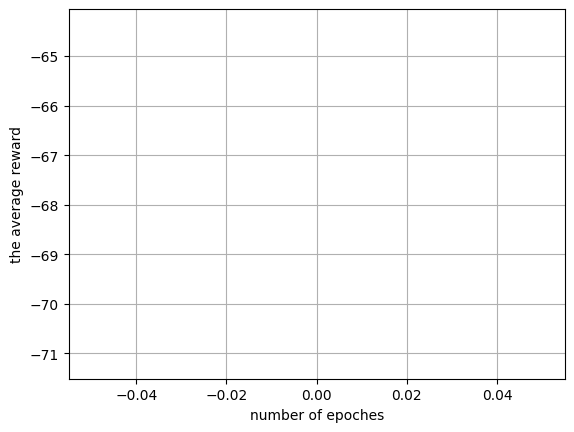

In [28]:
print(all_rewards)
plt.plot(all_rewards)
plt.xlabel('number of epoches')
plt.ylabel('the average reward')
plt.savefig("//data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/SHREC/images/DRLDDNet_14_reward.png")
plt.grid()

In [29]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew))):
    w_p = np.copy(x_trnew[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 116.52it/s]


In [30]:
# it may takes several times to reach the reported performance

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0812 - accuracy: 0.9852 - val_loss: 0.3460 - val_accuracy: 0.9107
Epoch 2/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.1503 - accuracy: 0.9622 - val_loss: 0.2291 - val_accuracy: 0.9417
Epoch 3/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.1264 - accuracy: 0.9668 - val_loss: 0.2498 - val_accuracy: 0.9393
Epoch 4/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.1073 - accuracy: 0.9791 - val_loss: 0.2697 - val_accuracy: 0.9262
Epoch 5/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.1061 - accuracy: 0.9765 - val_loss: 0.2803 - val_accuracy: 0.9310
Epoch 6/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.1100 - accuracy: 0.9765 - val_loss: 0.2826 - val_accuracy: 0.9298
Epoch 7/600
1960/1960 [==============================] - 0s 132us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0181 - accuracy: 0.9980 - val_loss: 0.2324 - val_accuracy: 0.9452
Epoch 58/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0183 - accuracy: 0.9980 - val_loss: 0.2190 - val_accuracy: 0.9488
Epoch 59/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0189 - accuracy: 0.9980 - val_loss: 0.2026 - val_accuracy: 0.9512
Epoch 60/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0187 - accuracy: 0.9980 - val_loss: 0.1963 - val_accuracy: 0.9548
Epoch 61/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0158 - accuracy: 0.9990 - val_loss: 0.1947 - val_accuracy: 0.9524
Epoch 62/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0169 - accuracy: 0.9980 - val_loss: 0.1955 - val_accuracy: 0.9524
Epoch 63/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0137 - accuracy: 0.9995 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.1866 - val_accuracy: 0.9524
Epoch 114/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0139 - accuracy: 0.9995 - val_loss: 0.1865 - val_accuracy: 0.9536
Epoch 115/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0126 - accuracy: 0.9990 - val_loss: 0.1863 - val_accuracy: 0.9548
Epoch 116/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0139 - accuracy: 0.9995 - val_loss: 0.1861 - val_accuracy: 0.9560
Epoch 117/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0140 - accuracy: 0.9990 - val_loss: 0.1859 - val_accuracy: 0.9560
Epoch 118/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0115 - accuracy: 0.9990 - val_loss: 0.1857 - val_accuracy: 0.9560
Epoch 119/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0121 - accuracy: 0.9995

Epoch 168/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0137 - accuracy: 0.9995 - val_loss: 0.1767 - val_accuracy: 0.9583
Epoch 169/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 0.1766 - val_accuracy: 0.9583
Epoch 170/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0169 - accuracy: 0.9974 - val_loss: 0.1765 - val_accuracy: 0.9583
Epoch 171/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0155 - accuracy: 0.9990 - val_loss: 0.1764 - val_accuracy: 0.9583
Epoch 172/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0169 - accuracy: 0.9974 - val_loss: 0.1763 - val_accuracy: 0.9583
Epoch 173/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0138 - accuracy: 0.9980 - val_loss: 0.1762 - val_accuracy: 0.9583
Epoch 174/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0172 - accuracy: 0.9974

Epoch 223/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0128 - accuracy: 0.9995 - val_loss: 0.1745 - val_accuracy: 0.9571
Epoch 224/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0118 - accuracy: 0.9995 - val_loss: 0.1745 - val_accuracy: 0.9571
Epoch 225/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0129 - accuracy: 0.9995 - val_loss: 0.1745 - val_accuracy: 0.9571
Epoch 226/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0131 - accuracy: 0.9990 - val_loss: 0.1744 - val_accuracy: 0.9571
Epoch 227/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.1744 - val_accuracy: 0.9571
Epoch 228/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0145 - accuracy: 0.9985 - val_loss: 0.1744 - val_accuracy: 0.9571
Epoch 229/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0143 - accuracy: 0.9985

Epoch 278/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0133 - accuracy: 0.9985 - val_loss: 0.1742 - val_accuracy: 0.9571
Epoch 279/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0151 - accuracy: 0.9990 - val_loss: 0.1741 - val_accuracy: 0.9571
Epoch 280/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.1741 - val_accuracy: 0.9571
Epoch 281/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0133 - accuracy: 0.9990 - val_loss: 0.1741 - val_accuracy: 0.9571
Epoch 282/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0167 - accuracy: 0.9985 - val_loss: 0.1742 - val_accuracy: 0.9571
Epoch 283/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0138 - accuracy: 0.9990 - val_loss: 0.1742 - val_accuracy: 0.9571
Epoch 284/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0148 - accuracy: 0.9990

Epoch 333/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0144 - accuracy: 0.9995 - val_loss: 0.1763 - val_accuracy: 0.9571
Epoch 334/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0156 - accuracy: 0.9974 - val_loss: 0.1763 - val_accuracy: 0.9571
Epoch 335/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0135 - accuracy: 0.9995 - val_loss: 0.1763 - val_accuracy: 0.9571
Epoch 336/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0118 - accuracy: 0.9990 - val_loss: 0.1763 - val_accuracy: 0.9560
Epoch 337/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.1763 - val_accuracy: 0.9560
Epoch 338/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0123 - accuracy: 0.9995 - val_loss: 0.1763 - val_accuracy: 0.9560
Epoch 339/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0142 - accuracy: 0.9995

Epoch 388/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.1758 - val_accuracy: 0.9571
Epoch 389/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0123 - accuracy: 0.9990 - val_loss: 0.1758 - val_accuracy: 0.9571
Epoch 390/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0133 - accuracy: 0.9995 - val_loss: 0.1758 - val_accuracy: 0.9571
Epoch 391/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0144 - accuracy: 0.9985 - val_loss: 0.1758 - val_accuracy: 0.9571
Epoch 392/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0128 - accuracy: 0.9995 - val_loss: 0.1758 - val_accuracy: 0.9571
Epoch 393/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0119 - accuracy: 0.9995 - val_loss: 0.1758 - val_accuracy: 0.9571
Epoch 394/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0135 - accuracy: 0.9990

Epoch 443/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0140 - accuracy: 0.9985 - val_loss: 0.1753 - val_accuracy: 0.9560
Epoch 444/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0120 - accuracy: 0.9985 - val_loss: 0.1753 - val_accuracy: 0.9560
Epoch 445/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0142 - accuracy: 0.9980 - val_loss: 0.1754 - val_accuracy: 0.9560
Epoch 446/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0145 - accuracy: 0.9985 - val_loss: 0.1754 - val_accuracy: 0.9560
Epoch 447/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0124 - accuracy: 0.9985 - val_loss: 0.1754 - val_accuracy: 0.9560
Epoch 448/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0135 - accuracy: 0.9995 - val_loss: 0.1754 - val_accuracy: 0.9560
Epoch 449/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0139 - accuracy: 0.9995

Epoch 498/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.1753 - val_accuracy: 0.9560
Epoch 499/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0124 - accuracy: 0.9995 - val_loss: 0.1754 - val_accuracy: 0.9560
Epoch 500/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.1755 - val_accuracy: 0.9560
Epoch 501/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0120 - accuracy: 0.9995 - val_loss: 0.1756 - val_accuracy: 0.9560
Epoch 502/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0126 - accuracy: 0.9995 - val_loss: 0.1757 - val_accuracy: 0.9560
Epoch 503/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0141 - accuracy: 0.9980 - val_loss: 0.1757 - val_accuracy: 0.9560
Epoch 504/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0120 - accuracy: 0.9995

Epoch 553/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0127 - accuracy: 0.9990 - val_loss: 0.1754 - val_accuracy: 0.9560
Epoch 554/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0095 - accuracy: 0.9995 - val_loss: 0.1754 - val_accuracy: 0.9560
Epoch 555/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0149 - accuracy: 0.9985 - val_loss: 0.1753 - val_accuracy: 0.9571
Epoch 556/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.1753 - val_accuracy: 0.9571
Epoch 557/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0115 - accuracy: 0.9995 - val_loss: 0.1752 - val_accuracy: 0.9571
Epoch 558/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0124 - accuracy: 0.9990 - val_loss: 0.1752 - val_accuracy: 0.9571
Epoch 559/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0130 - accuracy: 0.9990

In [31]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [32]:
labels_train = ['Grab', 'Tap','Expand','Pinch', 'RC', 'RCC','SR', 'SL', 'SU', 'SD','SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels_train[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels_train[i])

In [33]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9583333333333334


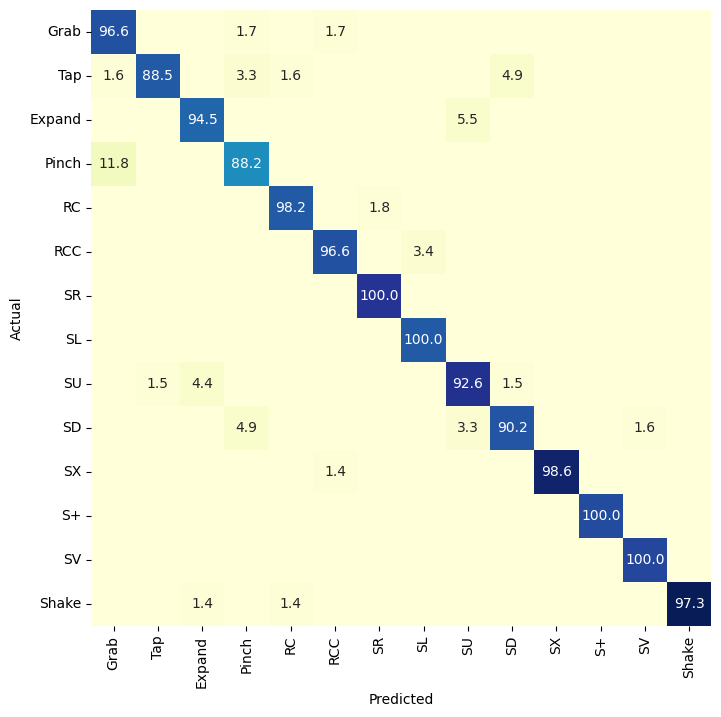

In [34]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_test4.png', labels_train, ymap=None, figsize=(8,8))

### epoch 2 

In [35]:
all_rewards,x_trnew_2,policy_net=train(x_trnew,labels_original)

  5%|█▉                                       | 95/1960 [01:12<23:34,  1.32it/s]


 10%|███▉                                    | 192/1960 [02:29<23:47,  1.24it/s]


 15%|█████▉                                  | 289/1960 [03:47<22:22,  1.24it/s]


 20%|███████▉                                | 386/1960 [05:04<20:57,  1.25it/s]


 25%|█████████▊                              | 483/1960 [06:20<18:58,  1.30it/s]


 30%|███████████▊                            | 580/1960 [07:36<18:31,  1.24it/s]


 35%|█████████████▊                          | 677/1960 [08:54<16:44,  1.28it/s]


 39%|███████████████▊                        | 774/1960 [10:07<15:48,  1.25it/s]


 44%|█████████████████▊                      | 871/1960 [11:24<14:15,  1.27it/s]


 49%|███████████████████▊                    | 968/1960 [12:40<12:41,  1.30it/s]


 54%|█████████████████████▏                 | 1065/1960 [13:58<11:51,  1.26it/s]


 59%|███████████████████████                | 1162/1960 [15:15<10:16,  1.30it/s]


 64%|█████████████████████████              | 1259/1960 [16:32<09:08,  1.28it/s]


 69%|██████████████████████████▉            | 1356/1960 [17:48<07:05,  1.42it/s]


 74%|████████████████████████████▉          | 1453/1960 [19:00<06:33,  1.29it/s]


 79%|██████████████████████████████▊        | 1550/1960 [20:17<05:29,  1.24it/s]


 84%|████████████████████████████████▊      | 1647/1960 [21:34<04:07,  1.27it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [22:47<02:54,  1.23it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [24:03<01:34,  1.26it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [25:20<00:17,  1.26it/s]


100%|███████████████████████████████████████████| 1/1 [25:37<00:00, 1537.47s/it]


[-61.25]


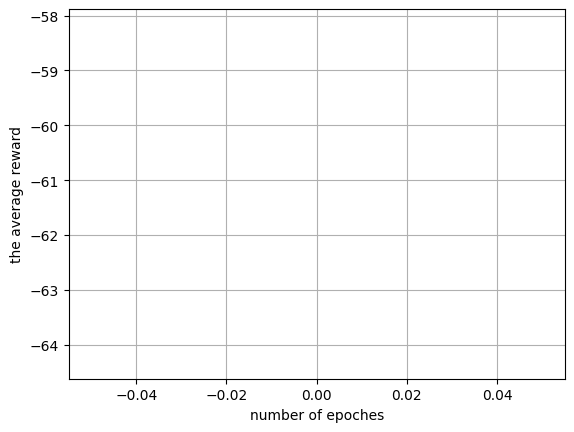

In [36]:
print(all_rewards)
plt.plot(all_rewards)
plt.xlabel('number of epoches')
plt.ylabel('the average reward')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_14_reward.png")
plt.grid()

In [37]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew_2))):
    w_p = np.copy(x_trnew_2[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 122.01it/s]


In [38]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.2527 - val_accuracy: 0.9476
Epoch 2/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0383 - accuracy: 0.9913 - val_loss: 0.2738 - val_accuracy: 0.9440
Epoch 3/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0742 - accuracy: 0.9801 - val_loss: 0.1862 - val_accuracy: 0.9583
Epoch 4/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0147 - accuracy: 0.9980 - val_loss: 0.3020 - val_accuracy: 0.9417
Epoch 5/600
1960/1960 [==============================] - 0s 122us/step - loss: 0.0523 - accuracy: 0.9898 - val_loss: 0.3084 - val_accuracy: 0.9429
Epoch 6/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0442 - accuracy: 0.9883 - val_loss: 0.2746 - val_accuracy: 0.9429
Epoch 7/600
1960/1960 [==============================] - 0s 122us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 118us/step - loss: 0.0088 - accuracy: 0.9995 - val_loss: 0.2137 - val_accuracy: 0.9607
Epoch 58/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0087 - accuracy: 0.9990 - val_loss: 0.2130 - val_accuracy: 0.9607
Epoch 59/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0088 - accuracy: 0.9995 - val_loss: 0.2124 - val_accuracy: 0.9607
Epoch 60/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0116 - accuracy: 0.9990 - val_loss: 0.2117 - val_accuracy: 0.9607
Epoch 61/600
1960/1960 [==============================] - 0s 118us/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.2114 - val_accuracy: 0.9607
Epoch 62/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0107 - accuracy: 0.9990 - val_loss: 0.2111 - val_accuracy: 0.9619
Epoch 63/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0106 - accuracy: 0.9980 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0100 - accuracy: 0.9985 - val_loss: 0.2030 - val_accuracy: 0.9607
Epoch 114/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0082 - accuracy: 0.9995 - val_loss: 0.2029 - val_accuracy: 0.9607
Epoch 115/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0084 - accuracy: 0.9995 - val_loss: 0.2029 - val_accuracy: 0.9607
Epoch 116/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0089 - accuracy: 0.9990 - val_loss: 0.2028 - val_accuracy: 0.9607
Epoch 117/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0086 - accuracy: 0.9995 - val_loss: 0.2027 - val_accuracy: 0.9607
Epoch 118/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0097 - accuracy: 0.9980 - val_loss: 0.2027 - val_accuracy: 0.9607
Epoch 119/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0115 - accuracy: 0.9985

Epoch 168/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0074 - accuracy: 0.9995 - val_loss: 0.2009 - val_accuracy: 0.9607
Epoch 169/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0081 - accuracy: 0.9995 - val_loss: 0.2009 - val_accuracy: 0.9607
Epoch 170/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0106 - accuracy: 0.9995 - val_loss: 0.2008 - val_accuracy: 0.9607
Epoch 171/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0103 - accuracy: 0.9980 - val_loss: 0.2006 - val_accuracy: 0.9607
Epoch 172/600
1960/1960 [==============================] - 0s 153us/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.2005 - val_accuracy: 0.9607
Epoch 173/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0082 - accuracy: 0.9995 - val_loss: 0.2004 - val_accuracy: 0.9607
Epoch 174/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0087 - accuracy: 0.9990

Epoch 223/600
1960/1960 [==============================] - 0s 118us/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.1978 - val_accuracy: 0.9607
Epoch 224/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.1978 - val_accuracy: 0.9607
Epoch 225/600
1960/1960 [==============================] - 0s 117us/step - loss: 0.0098 - accuracy: 0.9995 - val_loss: 0.1978 - val_accuracy: 0.9607
Epoch 226/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0101 - accuracy: 0.9990 - val_loss: 0.1979 - val_accuracy: 0.9607
Epoch 227/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.1979 - val_accuracy: 0.9607
Epoch 228/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1979 - val_accuracy: 0.9607
Epoch 229/600
1960/1960 [==============================] - 0s 118us/step - loss: 0.0080 - accuracy: 0.9995

Epoch 278/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0085 - accuracy: 0.9995 - val_loss: 0.1978 - val_accuracy: 0.9607
Epoch 279/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.1978 - val_accuracy: 0.9607
Epoch 280/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.1977 - val_accuracy: 0.9607
Epoch 281/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0093 - accuracy: 0.9990 - val_loss: 0.1977 - val_accuracy: 0.9607
Epoch 282/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.1976 - val_accuracy: 0.9607
Epoch 283/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0087 - accuracy: 0.9990 - val_loss: 0.1976 - val_accuracy: 0.9607
Epoch 284/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0088 - accuracy: 1.0000

Epoch 333/600
1960/1960 [==============================] - 0s 118us/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.1970 - val_accuracy: 0.9607
Epoch 334/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0077 - accuracy: 0.9995 - val_loss: 0.1969 - val_accuracy: 0.9607
Epoch 335/600
1960/1960 [==============================] - 0s 123us/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.1969 - val_accuracy: 0.9607
Epoch 336/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.1968 - val_accuracy: 0.9607
Epoch 337/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0097 - accuracy: 0.9995 - val_loss: 0.1968 - val_accuracy: 0.9607
Epoch 338/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0092 - accuracy: 0.9995 - val_loss: 0.1967 - val_accuracy: 0.9607
Epoch 339/600
1960/1960 [==============================] - 0s 116us/step - loss: 0.0089 - accuracy: 0.9995

Epoch 388/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0076 - accuracy: 0.9990 - val_loss: 0.1976 - val_accuracy: 0.9607
Epoch 389/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.1975 - val_accuracy: 0.9607
Epoch 390/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0082 - accuracy: 0.9995 - val_loss: 0.1975 - val_accuracy: 0.9607
Epoch 391/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.1974 - val_accuracy: 0.9607
Epoch 392/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0090 - accuracy: 0.9995 - val_loss: 0.1974 - val_accuracy: 0.9607
Epoch 393/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0100 - accuracy: 0.9995 - val_loss: 0.1974 - val_accuracy: 0.9607
Epoch 394/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0083 - accuracy: 0.9995

Epoch 443/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0071 - accuracy: 0.9995 - val_loss: 0.1966 - val_accuracy: 0.9607
Epoch 444/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.1966 - val_accuracy: 0.9607
Epoch 445/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0081 - accuracy: 0.9995 - val_loss: 0.1967 - val_accuracy: 0.9607
Epoch 446/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1967 - val_accuracy: 0.9607
Epoch 447/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.1968 - val_accuracy: 0.9607
Epoch 448/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1968 - val_accuracy: 0.9607
Epoch 449/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0102 - accuracy: 0.9985

Epoch 498/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0094 - accuracy: 0.9985 - val_loss: 0.1959 - val_accuracy: 0.9607
Epoch 499/600
1960/1960 [==============================] - 0s 121us/step - loss: 0.0087 - accuracy: 0.9990 - val_loss: 0.1960 - val_accuracy: 0.9607
Epoch 500/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1960 - val_accuracy: 0.9607
Epoch 501/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.1959 - val_accuracy: 0.9607
Epoch 502/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0074 - accuracy: 0.9995 - val_loss: 0.1959 - val_accuracy: 0.9607
Epoch 503/600
1960/1960 [==============================] - 0s 119us/step - loss: 0.0069 - accuracy: 0.9995 - val_loss: 0.1959 - val_accuracy: 0.9607
Epoch 504/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0093 - accuracy: 0.9985

Epoch 553/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.1959 - val_accuracy: 0.9607
Epoch 554/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0072 - accuracy: 0.9990 - val_loss: 0.1959 - val_accuracy: 0.9607
Epoch 555/600
1960/1960 [==============================] - 0s 124us/step - loss: 0.0083 - accuracy: 0.9995 - val_loss: 0.1958 - val_accuracy: 0.9607
Epoch 556/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0069 - accuracy: 0.9995 - val_loss: 0.1958 - val_accuracy: 0.9607
Epoch 557/600
1960/1960 [==============================] - 0s 120us/step - loss: 0.0076 - accuracy: 0.9990 - val_loss: 0.1958 - val_accuracy: 0.9607
Epoch 558/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0088 - accuracy: 0.9990 - val_loss: 0.1958 - val_accuracy: 0.9607
Epoch 559/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0077 - accuracy: 0.9995

In [39]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['Grab', 'Tap','Expand','Pinch', 'RC', 'RCC','SR', 'SL', 'SU', 'SD','SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9607142857142857


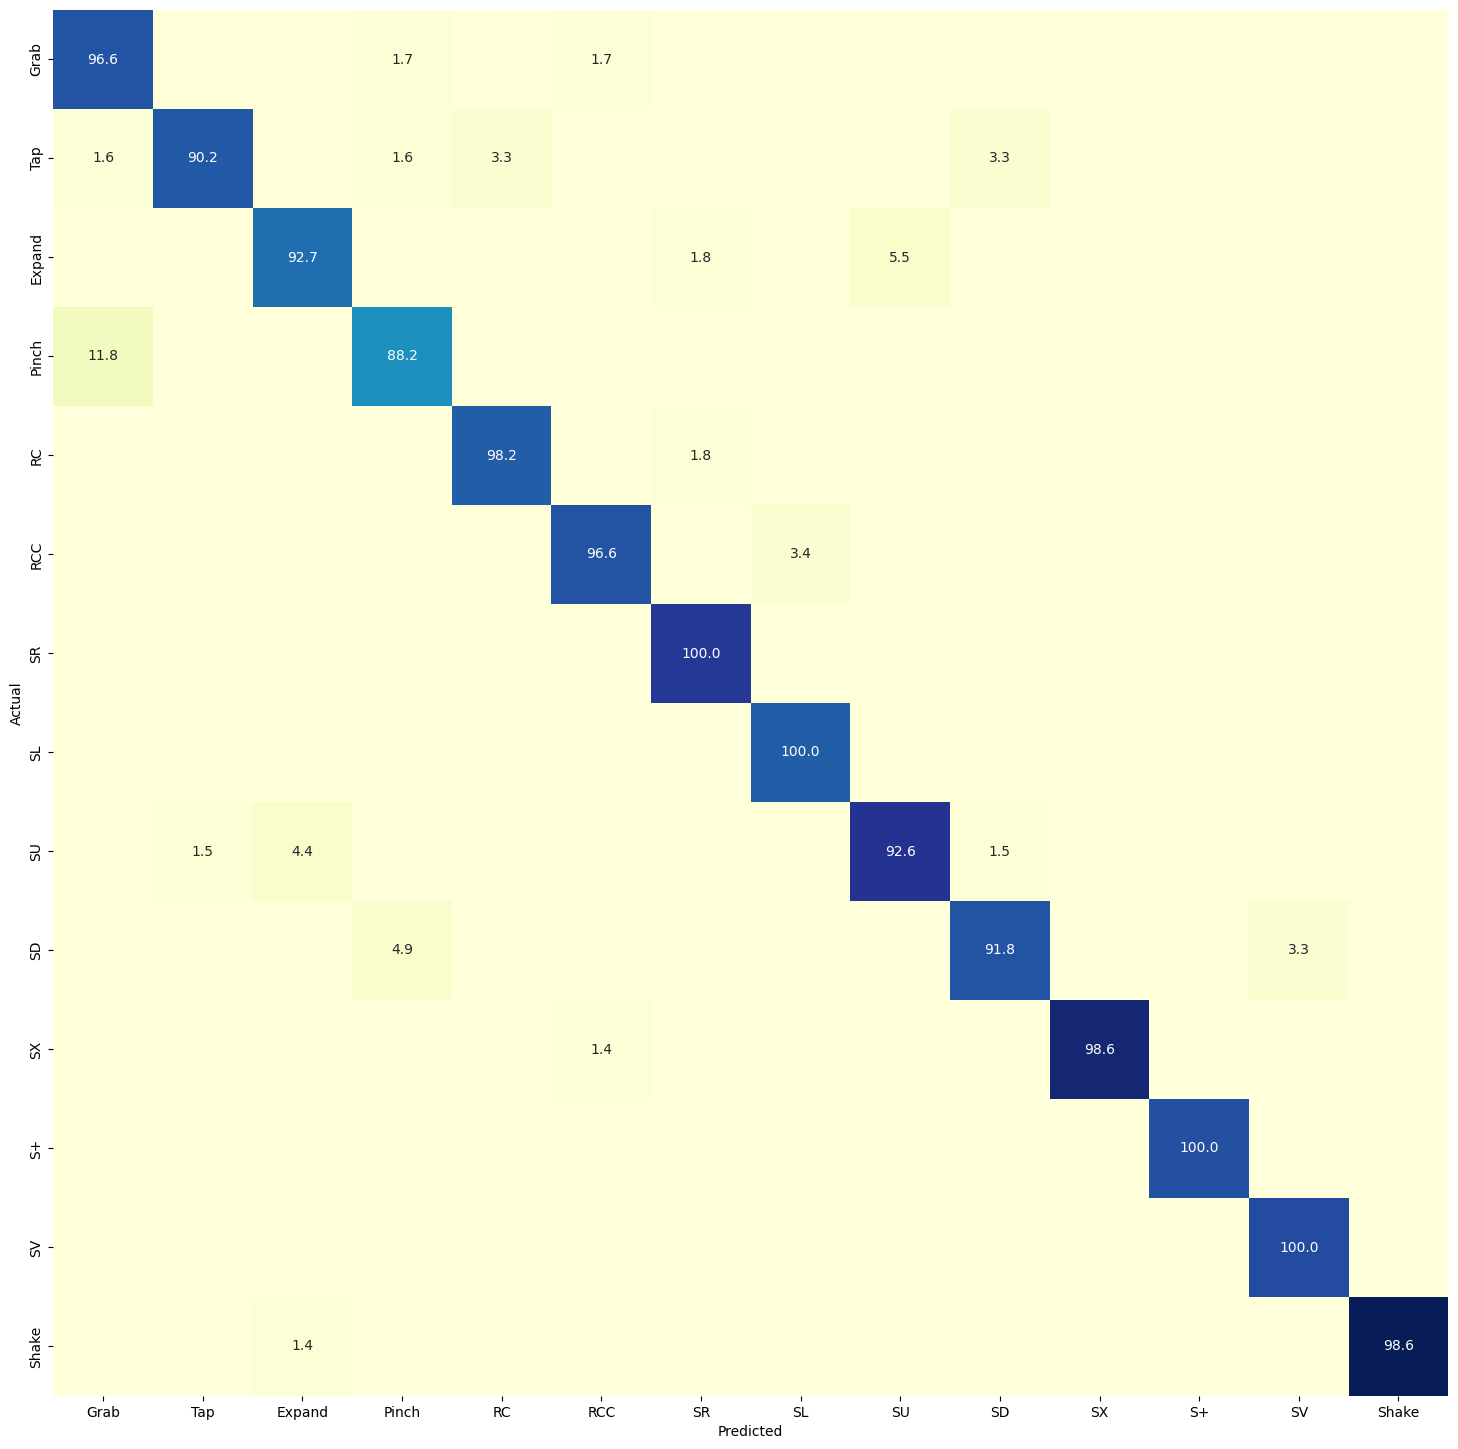

In [40]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_5.png', labels, ymap=None, figsize=(18,18))

### epoch 3 

In [41]:
all_rewards,x_trnew_3,policy_net=train(x_trnew_2,labels_original)
print(all_rewards)
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_3))):
    w_p = np.copy(x_trnew_3[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

  5%|█▉                                       | 95/1960 [01:10<23:03,  1.35it/s]


 10%|███▉                                    | 192/1960 [02:21<20:21,  1.45it/s]


 15%|█████▉                                  | 289/1960 [03:31<20:35,  1.35it/s]


 20%|███████▉                                | 386/1960 [04:42<19:08,  1.37it/s]


 25%|█████████▊                              | 483/1960 [05:53<18:38,  1.32it/s]


 30%|███████████▊                            | 580/1960 [07:03<16:48,  1.37it/s]


 35%|█████████████▊                          | 677/1960 [08:14<15:48,  1.35it/s]


 39%|███████████████▊                        | 774/1960 [09:25<14:58,  1.32it/s]


 44%|█████████████████▊                      | 871/1960 [10:36<12:40,  1.43it/s]


 49%|███████████████████▊                    | 968/1960 [11:46<12:17,  1.35it/s]


 54%|█████████████████████▏                 | 1065/1960 [12:57<10:58,  1.36it/s]


 59%|███████████████████████                | 1162/1960 [14:06<09:48,  1.36it/s]


 64%|█████████████████████████              | 1259/1960 [15:21<09:14,  1.26it/s]


 69%|██████████████████████████▉            | 1356/1960 [16:38<08:04,  1.25it/s]


 74%|████████████████████████████▉          | 1453/1960 [17:55<06:45,  1.25it/s]


 79%|██████████████████████████████▊        | 1550/1960 [19:08<04:53,  1.40it/s]


 84%|████████████████████████████████▊      | 1647/1960 [20:19<03:43,  1.40it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [21:32<02:50,  1.27it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [22:49<01:35,  1.24it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [24:07<00:18,  1.22it/s]


100%|███████████████████████████████████████████| 1/1 [24:24<00:00, 1464.07s/it]


[-61.25]


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.71it/s]


In [42]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.2023 - val_accuracy: 0.9583
Epoch 2/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0202 - accuracy: 0.9969 - val_loss: 0.2294 - val_accuracy: 0.9464
Epoch 3/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0225 - accuracy: 0.9959 - val_loss: 0.2216 - val_accuracy: 0.9488
Epoch 4/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0261 - accuracy: 0.9939 - val_loss: 0.2353 - val_accuracy: 0.9476
Epoch 5/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0156 - accuracy: 0.9969 - val_loss: 0.2739 - val_accuracy: 0.9464
Epoch 6/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0183 - accuracy: 0.9964 - val_loss: 0.2855 - val_accuracy: 0.9417
Epoch 7/600
1960/1960 [==============================] - 0s 129us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0077 - accuracy: 0.9995 - val_loss: 0.2177 - val_accuracy: 0.9560
Epoch 58/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.2173 - val_accuracy: 0.9560
Epoch 59/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0073 - accuracy: 0.9985 - val_loss: 0.2168 - val_accuracy: 0.9560
Epoch 60/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0080 - accuracy: 0.9990 - val_loss: 0.2164 - val_accuracy: 0.9571
Epoch 61/600
1960/1960 [==============================] - 0s 150us/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.2160 - val_accuracy: 0.9571
Epoch 62/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0080 - accuracy: 0.9985 - val_loss: 0.2156 - val_accuracy: 0.9583
Epoch 63/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0057 - accuracy: 1.0000 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0067 - accuracy: 0.9995 - val_loss: 0.2076 - val_accuracy: 0.9631
Epoch 114/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0066 - accuracy: 0.9995 - val_loss: 0.2074 - val_accuracy: 0.9631
Epoch 115/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0067 - accuracy: 0.9995 - val_loss: 0.2072 - val_accuracy: 0.9631
Epoch 116/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0056 - accuracy: 0.9995 - val_loss: 0.2071 - val_accuracy: 0.9631
Epoch 117/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0053 - accuracy: 0.9995 - val_loss: 0.2069 - val_accuracy: 0.9631
Epoch 118/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0059 - accuracy: 0.9995 - val_loss: 0.2068 - val_accuracy: 0.9631
Epoch 119/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0052 - accuracy: 1.0000

Epoch 168/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0079 - accuracy: 0.9990 - val_loss: 0.2046 - val_accuracy: 0.9619
Epoch 169/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0074 - accuracy: 0.9990 - val_loss: 0.2046 - val_accuracy: 0.9619
Epoch 170/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.2046 - val_accuracy: 0.9619
Epoch 171/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2046 - val_accuracy: 0.9619
Epoch 172/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0059 - accuracy: 0.9995 - val_loss: 0.2045 - val_accuracy: 0.9619
Epoch 173/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0059 - accuracy: 0.9995 - val_loss: 0.2045 - val_accuracy: 0.9619
Epoch 174/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0085 - accuracy: 0.9990

Epoch 223/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0061 - accuracy: 0.9995 - val_loss: 0.2014 - val_accuracy: 0.9619
Epoch 224/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0077 - accuracy: 0.9995 - val_loss: 0.2013 - val_accuracy: 0.9619
Epoch 225/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.2013 - val_accuracy: 0.9619
Epoch 226/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.2012 - val_accuracy: 0.9619
Epoch 227/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0089 - accuracy: 0.9985 - val_loss: 0.2011 - val_accuracy: 0.9619
Epoch 228/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0067 - accuracy: 0.9990 - val_loss: 0.2010 - val_accuracy: 0.9619
Epoch 229/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0054 - accuracy: 1.0000

Epoch 278/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0068 - accuracy: 0.9985 - val_loss: 0.1975 - val_accuracy: 0.9631
Epoch 279/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 0.1974 - val_accuracy: 0.9631
Epoch 280/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1974 - val_accuracy: 0.9631
Epoch 281/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0085 - accuracy: 0.9995 - val_loss: 0.1974 - val_accuracy: 0.9631
Epoch 282/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.1974 - val_accuracy: 0.9631
Epoch 283/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.1974 - val_accuracy: 0.9631
Epoch 284/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0050 - accuracy: 1.0000

Epoch 333/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.1979 - val_accuracy: 0.9631
Epoch 334/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0062 - accuracy: 0.9995 - val_loss: 0.1979 - val_accuracy: 0.9631
Epoch 335/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0068 - accuracy: 0.9990 - val_loss: 0.1979 - val_accuracy: 0.9631
Epoch 336/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0053 - accuracy: 0.9995 - val_loss: 0.1979 - val_accuracy: 0.9631
Epoch 337/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0079 - accuracy: 0.9995 - val_loss: 0.1979 - val_accuracy: 0.9631
Epoch 338/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0070 - accuracy: 0.9995 - val_loss: 0.1978 - val_accuracy: 0.9631
Epoch 339/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0088 - accuracy: 0.9990

Epoch 388/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.1973 - val_accuracy: 0.9643
Epoch 389/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0071 - accuracy: 0.9985 - val_loss: 0.1974 - val_accuracy: 0.9643
Epoch 390/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0055 - accuracy: 0.9995 - val_loss: 0.1975 - val_accuracy: 0.9643
Epoch 391/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.1976 - val_accuracy: 0.9643
Epoch 392/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.1977 - val_accuracy: 0.9631
Epoch 393/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0069 - accuracy: 0.9990 - val_loss: 0.1977 - val_accuracy: 0.9631
Epoch 394/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0047 - accuracy: 1.0000

Epoch 443/600
1960/1960 [==============================] - 0s 125us/step - loss: 0.0064 - accuracy: 0.9995 - val_loss: 0.1995 - val_accuracy: 0.9619
Epoch 444/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.1995 - val_accuracy: 0.9619
Epoch 445/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.1994 - val_accuracy: 0.9619
Epoch 446/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.1994 - val_accuracy: 0.9619
Epoch 447/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0072 - accuracy: 0.9990 - val_loss: 0.1993 - val_accuracy: 0.9619
Epoch 448/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.1992 - val_accuracy: 0.9619
Epoch 449/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0042 - accuracy: 1.0000

Epoch 498/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.1971 - val_accuracy: 0.9643
Epoch 499/600
1960/1960 [==============================] - 0s 126us/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.1970 - val_accuracy: 0.9643
Epoch 500/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0060 - accuracy: 0.9990 - val_loss: 0.1969 - val_accuracy: 0.9643
Epoch 501/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1968 - val_accuracy: 0.9643
Epoch 502/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0044 - accuracy: 0.9995 - val_loss: 0.1967 - val_accuracy: 0.9643
Epoch 503/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0053 - accuracy: 0.9995 - val_loss: 0.1965 - val_accuracy: 0.9643
Epoch 504/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0068 - accuracy: 0.9990

Epoch 553/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0078 - accuracy: 0.9985 - val_loss: 0.1983 - val_accuracy: 0.9655
Epoch 554/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1983 - val_accuracy: 0.9655
Epoch 555/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0062 - accuracy: 0.9995 - val_loss: 0.1984 - val_accuracy: 0.9655
Epoch 556/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.1984 - val_accuracy: 0.9655
Epoch 557/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.1984 - val_accuracy: 0.9655
Epoch 558/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0064 - accuracy: 0.9995 - val_loss: 0.1984 - val_accuracy: 0.9655
Epoch 559/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0067 - accuracy: 0.9995

In [43]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['Grab', 'Tap','Expand','Pinch', 'RC', 'RCC','SR', 'SL', 'SU', 'SD','SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9642857142857143


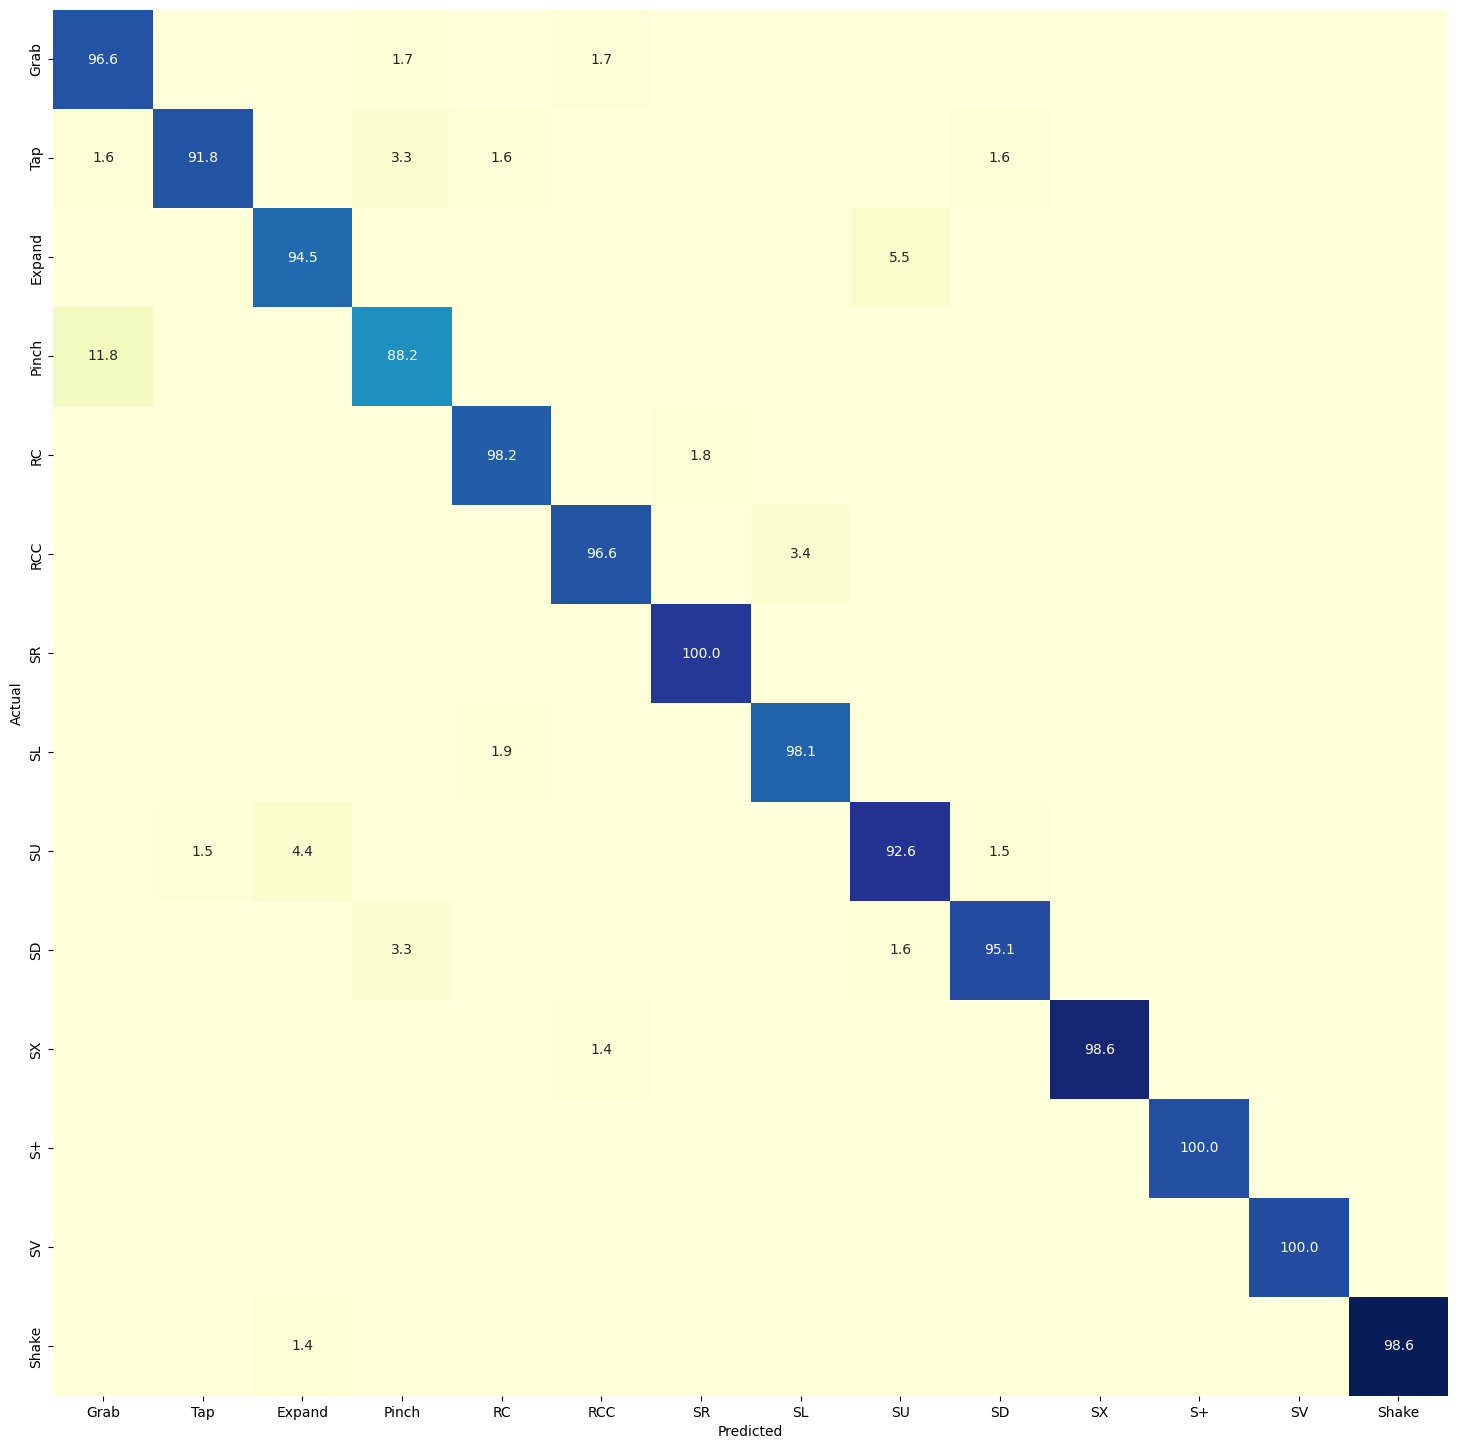

In [44]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_6.png', labels, ymap=None, figsize=(18,18))

### epoch 4

In [45]:
all_rewards,x_trnew_4,policy_net=train(x_trnew_3,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_4))):
    w_p = np.copy(x_trnew_4[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

  5%|█▉                                       | 95/1960 [01:08<22:54,  1.36it/s]


 10%|███▉                                    | 192/1960 [02:17<21:29,  1.37it/s]


 15%|█████▉                                  | 289/1960 [03:31<20:39,  1.35it/s]


 20%|███████▉                                | 386/1960 [04:40<18:14,  1.44it/s]


 25%|█████████▊                              | 483/1960 [05:51<17:53,  1.38it/s]


 30%|███████████▊                            | 580/1960 [07:00<16:46,  1.37it/s]


 35%|█████████████▊                          | 677/1960 [08:10<15:11,  1.41it/s]


 39%|███████████████▊                        | 774/1960 [09:20<13:38,  1.45it/s]


 44%|█████████████████▊                      | 871/1960 [10:29<13:27,  1.35it/s]


 49%|███████████████████▊                    | 968/1960 [11:39<11:46,  1.40it/s]


 54%|█████████████████████▏                 | 1065/1960 [12:49<10:36,  1.41it/s]


 59%|███████████████████████                | 1162/1960 [14:03<10:41,  1.24it/s]


 64%|█████████████████████████              | 1259/1960 [15:16<08:30,  1.37it/s]


 69%|██████████████████████████▉            | 1356/1960 [16:26<07:10,  1.40it/s]


 74%|████████████████████████████▉          | 1453/1960 [17:38<06:49,  1.24it/s]


 79%|██████████████████████████████▊        | 1550/1960 [18:49<05:23,  1.27it/s]


 84%|████████████████████████████████▊      | 1647/1960 [20:05<04:13,  1.24it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [21:21<02:51,  1.26it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [22:37<01:31,  1.30it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [23:54<00:17,  1.27it/s]


100%|███████████████████████████████████████████| 1/1 [24:11<00:00, 1451.70s/it]


[-61.25]


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 119.33it/s]


In [46]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2088 - val_accuracy: 0.9583
Epoch 2/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0101 - accuracy: 0.9974 - val_loss: 0.2514 - val_accuracy: 0.9512
Epoch 3/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0196 - accuracy: 0.9954 - val_loss: 0.3062 - val_accuracy: 0.9345
Epoch 4/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0157 - accuracy: 0.9954 - val_loss: 0.4094 - val_accuracy: 0.9250
Epoch 5/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0460 - accuracy: 0.9893 - val_loss: 0.2442 - val_accuracy: 0.9560
Epoch 6/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0221 - accuracy: 0.9949 - val_loss: 0.3074 - val_accuracy: 0.9393
Epoch 7/600
1960/1960 [==============================] - 0s 133us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.2247 - val_accuracy: 0.9631
Epoch 58/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0072 - accuracy: 0.9985 - val_loss: 0.2246 - val_accuracy: 0.9631
Epoch 59/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.2246 - val_accuracy: 0.9631
Epoch 60/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.2244 - val_accuracy: 0.9631
Epoch 61/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0062 - accuracy: 0.9995 - val_loss: 0.2243 - val_accuracy: 0.9631
Epoch 62/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0080 - accuracy: 0.9990 - val_loss: 0.2241 - val_accuracy: 0.9631
Epoch 63/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0078 - accuracy: 0.9985 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0058 - accuracy: 0.9995 - val_loss: 0.2195 - val_accuracy: 0.9607
Epoch 114/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.2195 - val_accuracy: 0.9607
Epoch 115/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.2196 - val_accuracy: 0.9607
Epoch 116/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.2196 - val_accuracy: 0.9607
Epoch 117/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0061 - accuracy: 0.9995 - val_loss: 0.2196 - val_accuracy: 0.9607
Epoch 118/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0053 - accuracy: 0.9995 - val_loss: 0.2196 - val_accuracy: 0.9607
Epoch 119/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0065 - accuracy: 0.9995

Epoch 168/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.2200 - val_accuracy: 0.9607
Epoch 169/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0061 - accuracy: 0.9995 - val_loss: 0.2200 - val_accuracy: 0.9607
Epoch 170/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2201 - val_accuracy: 0.9607
Epoch 171/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.2201 - val_accuracy: 0.9607
Epoch 172/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.2201 - val_accuracy: 0.9607
Epoch 173/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.2202 - val_accuracy: 0.9607
Epoch 174/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0047 - accuracy: 1.0000

Epoch 223/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0073 - accuracy: 0.9990 - val_loss: 0.2214 - val_accuracy: 0.9595
Epoch 224/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.2214 - val_accuracy: 0.9595
Epoch 225/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0063 - accuracy: 0.9995 - val_loss: 0.2214 - val_accuracy: 0.9595
Epoch 226/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.2213 - val_accuracy: 0.9595
Epoch 227/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0062 - accuracy: 0.9995 - val_loss: 0.2213 - val_accuracy: 0.9595
Epoch 228/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0052 - accuracy: 0.9995 - val_loss: 0.2213 - val_accuracy: 0.9595
Epoch 229/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0087 - accuracy: 0.9980

Epoch 278/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0046 - accuracy: 0.9995 - val_loss: 0.2210 - val_accuracy: 0.9571
Epoch 279/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0076 - accuracy: 0.9980 - val_loss: 0.2210 - val_accuracy: 0.9571
Epoch 280/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.2211 - val_accuracy: 0.9571
Epoch 281/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 0.2211 - val_accuracy: 0.9571
Epoch 282/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0072 - accuracy: 0.9990 - val_loss: 0.2211 - val_accuracy: 0.9571
Epoch 283/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.2211 - val_accuracy: 0.9571
Epoch 284/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0050 - accuracy: 0.9995

Epoch 333/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.2215 - val_accuracy: 0.9560
Epoch 334/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0067 - accuracy: 0.9990 - val_loss: 0.2215 - val_accuracy: 0.9560
Epoch 335/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0078 - accuracy: 0.9990 - val_loss: 0.2214 - val_accuracy: 0.9560
Epoch 336/600
1960/1960 [==============================] - 0s 155us/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.2214 - val_accuracy: 0.9560
Epoch 337/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2214 - val_accuracy: 0.9560
Epoch 338/600
1960/1960 [==============================] - 0s 151us/step - loss: 0.0052 - accuracy: 0.9995 - val_loss: 0.2214 - val_accuracy: 0.9560
Epoch 339/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0056 - accuracy: 0.9995

Epoch 388/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.2201 - val_accuracy: 0.9583
Epoch 389/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.2200 - val_accuracy: 0.9583
Epoch 390/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.2200 - val_accuracy: 0.9583
Epoch 391/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0040 - accuracy: 0.9995 - val_loss: 0.2199 - val_accuracy: 0.9583
Epoch 392/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.2199 - val_accuracy: 0.9583
Epoch 393/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.2198 - val_accuracy: 0.9595
Epoch 394/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0042 - accuracy: 1.0000

Epoch 443/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0058 - accuracy: 0.9990 - val_loss: 0.2185 - val_accuracy: 0.9583
Epoch 444/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.2185 - val_accuracy: 0.9583
Epoch 445/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 0.2186 - val_accuracy: 0.9583
Epoch 446/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0055 - accuracy: 0.9995 - val_loss: 0.2186 - val_accuracy: 0.9583
Epoch 447/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.2186 - val_accuracy: 0.9583
Epoch 448/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0050 - accuracy: 0.9995 - val_loss: 0.2187 - val_accuracy: 0.9583
Epoch 449/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0048 - accuracy: 0.9995

Epoch 498/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0045 - accuracy: 0.9995 - val_loss: 0.2197 - val_accuracy: 0.9583
Epoch 499/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0046 - accuracy: 0.9995 - val_loss: 0.2197 - val_accuracy: 0.9583
Epoch 500/600
1960/1960 [==============================] - 0s 151us/step - loss: 0.0044 - accuracy: 0.9995 - val_loss: 0.2197 - val_accuracy: 0.9583
Epoch 501/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.2197 - val_accuracy: 0.9583
Epoch 502/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0054 - accuracy: 0.9995 - val_loss: 0.2198 - val_accuracy: 0.9583
Epoch 503/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.2198 - val_accuracy: 0.9583
Epoch 504/600
1960/1960 [==============================] - 0s 153us/step - loss: 0.0053 - accuracy: 0.9995

Epoch 553/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.2194 - val_accuracy: 0.9583
Epoch 554/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0064 - accuracy: 0.9995 - val_loss: 0.2194 - val_accuracy: 0.9583
Epoch 555/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 0.2193 - val_accuracy: 0.9583
Epoch 556/600
1960/1960 [==============================] - 0s 139us/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 0.2193 - val_accuracy: 0.9583
Epoch 557/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 0.2193 - val_accuracy: 0.9583
Epoch 558/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.2192 - val_accuracy: 0.9583
Epoch 559/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0046 - accuracy: 0.9995

In [47]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['Grab', 'Tap','Expand','Pinch', 'RC', 'RCC','SR', 'SL', 'SU', 'SD','SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9583333333333334


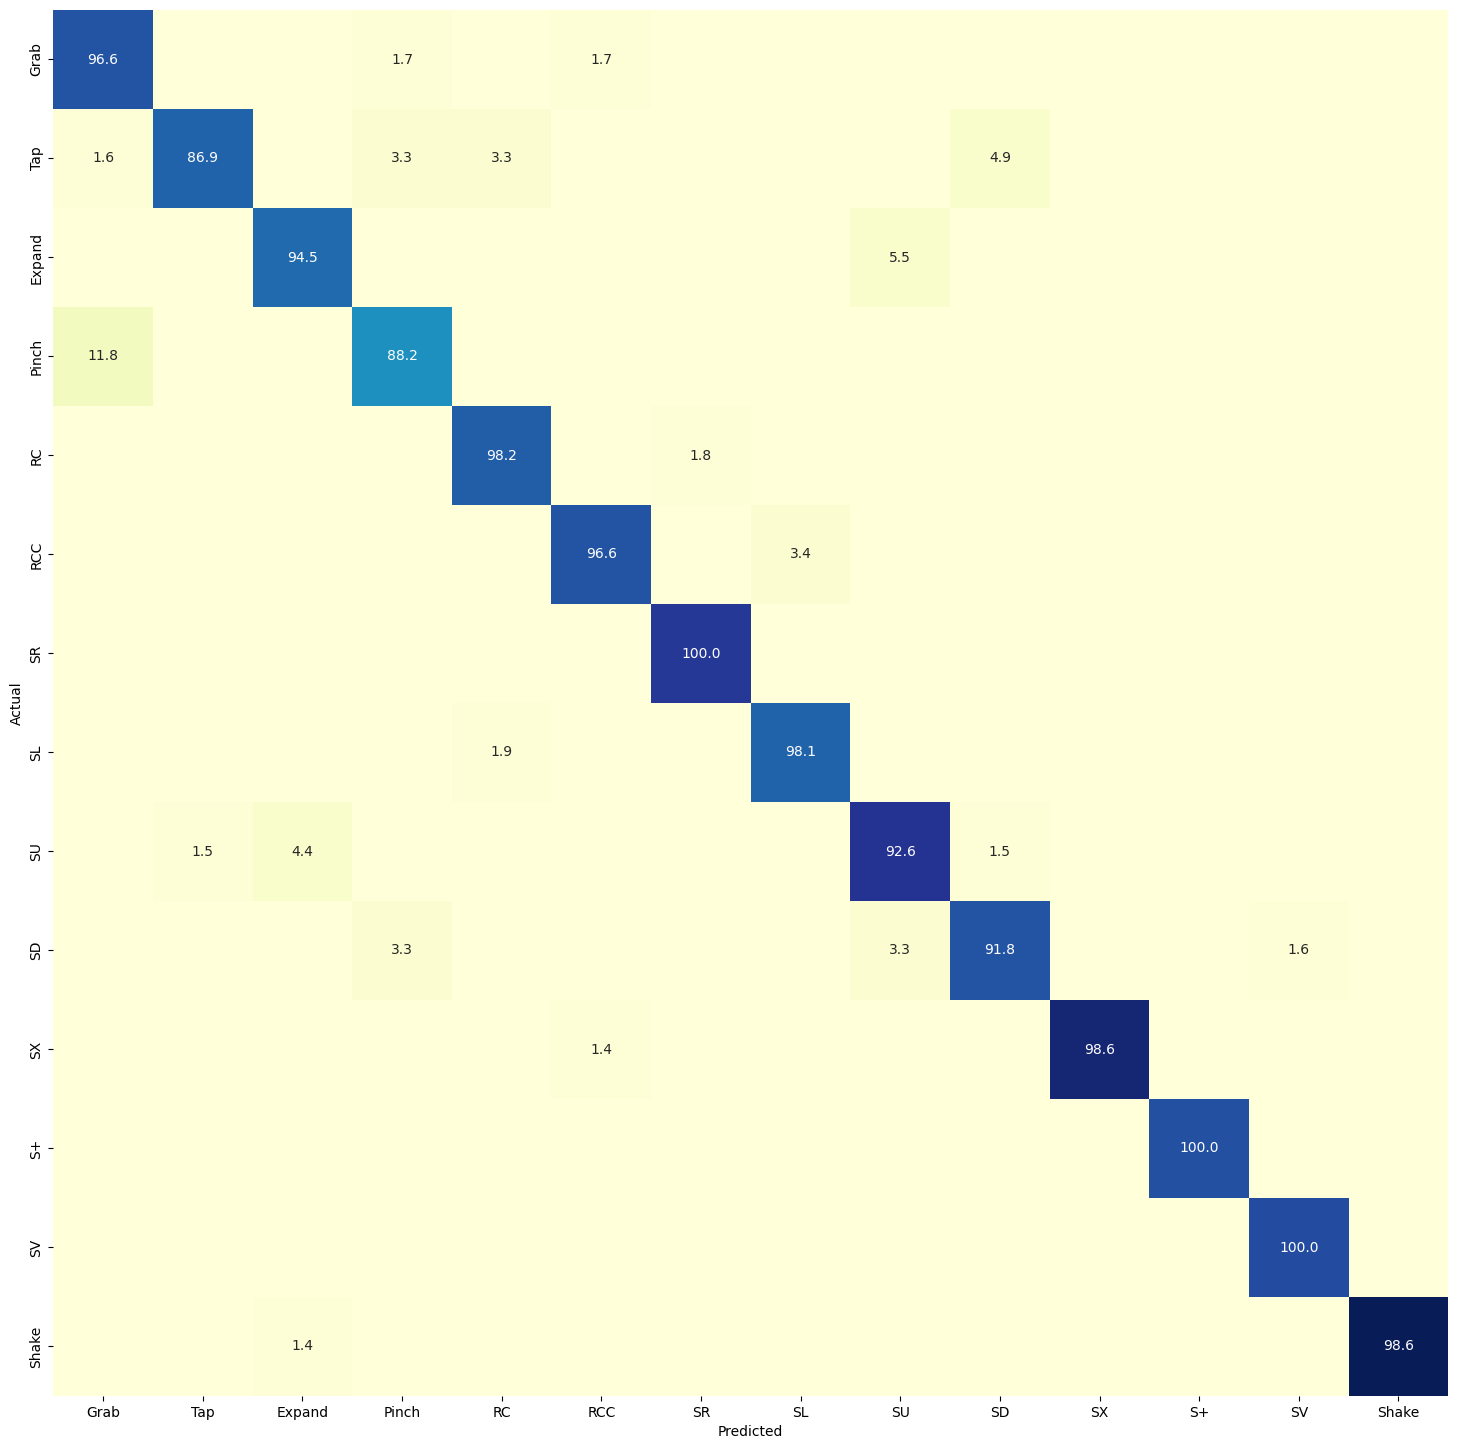

In [48]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_7.png', labels, ymap=None, figsize=(18,18))

### epoch 5 

In [49]:
all_rewards,x_trnew_5,policy_net=train(x_trnew_4,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_5))):
    w_p = np.copy(x_trnew_5[i]).reshape([-1,22,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

  5%|█▉                                       | 95/1960 [01:08<22:48,  1.36it/s]


 10%|███▉                                    | 192/1960 [02:19<21:36,  1.36it/s]


 15%|█████▉                                  | 289/1960 [03:35<21:51,  1.27it/s]


 20%|███████▉                                | 386/1960 [04:52<21:23,  1.23it/s]


 25%|█████████▊                              | 483/1960 [06:09<19:24,  1.27it/s]


 30%|███████████▊                            | 580/1960 [07:26<18:13,  1.26it/s]


 35%|█████████████▊                          | 677/1960 [08:44<17:02,  1.26it/s]


 39%|███████████████▊                        | 774/1960 [10:00<15:28,  1.28it/s]


 44%|█████████████████▊                      | 871/1960 [11:17<14:31,  1.25it/s]


 49%|███████████████████▊                    | 968/1960 [12:34<13:07,  1.26it/s]


 54%|█████████████████████▏                 | 1065/1960 [13:51<12:14,  1.22it/s]


 59%|███████████████████████                | 1162/1960 [15:08<10:43,  1.24it/s]


 64%|█████████████████████████              | 1259/1960 [16:25<09:24,  1.24it/s]


 69%|██████████████████████████▉            | 1356/1960 [17:41<07:51,  1.28it/s]


 74%|████████████████████████████▉          | 1453/1960 [18:57<06:58,  1.21it/s]


 79%|██████████████████████████████▊        | 1550/1960 [20:14<05:21,  1.28it/s]


 84%|████████████████████████████████▊      | 1647/1960 [21:31<04:10,  1.25it/s]


 89%|██████████████████████████████████▋    | 1744/1960 [22:48<02:54,  1.24it/s]


 94%|████████████████████████████████████▋  | 1841/1960 [24:05<01:35,  1.25it/s]


 99%|██████████████████████████████████████▌| 1938/1960 [25:23<00:17,  1.26it/s]


100%|███████████████████████████████████████████| 1/1 [25:40<00:00, 1540.76s/it]


[-61.25]


100%|██████████████████████████████████████| 1960/1960 [00:16<00:00, 118.48it/s]


In [50]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/600
1960/1960 [==============================] - 4s 2ms/step - loss: 0.0058 - accuracy: 0.9995 - val_loss: 0.3125 - val_accuracy: 0.9500
Epoch 2/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 0.2969 - val_accuracy: 0.9417
Epoch 3/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0393 - accuracy: 0.9893 - val_loss: 0.2852 - val_accuracy: 0.9464
Epoch 4/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0090 - accuracy: 0.9985 - val_loss: 0.3047 - val_accuracy: 0.9452
Epoch 5/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0212 - accuracy: 0.9964 - val_loss: 0.3024 - val_accuracy: 0.9524
Epoch 6/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0336 - accuracy: 0.9939 - val_loss: 0.3069 - val_accuracy: 0.9452
Epoch 7/600
1960/1960 [==============================] - 0s 136us/step - 

Epoch 57/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 0.2353 - val_accuracy: 0.9583
Epoch 58/600
1960/1960 [==============================] - 0s 146us/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.2368 - val_accuracy: 0.9595
Epoch 59/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.2380 - val_accuracy: 0.9595
Epoch 60/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.2393 - val_accuracy: 0.9595
Epoch 61/600
1960/1960 [==============================] - 0s 147us/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.2404 - val_accuracy: 0.9583
Epoch 62/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.2415 - val_accuracy: 0.9560
Epoch 63/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0027 - accuracy: 1.0000 - val_

Epoch 113/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2317 - val_accuracy: 0.9631
Epoch 114/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2315 - val_accuracy: 0.9631
Epoch 115/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2313 - val_accuracy: 0.9631
Epoch 116/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.2311 - val_accuracy: 0.9631
Epoch 117/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2310 - val_accuracy: 0.9631
Epoch 118/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 0.2308 - val_accuracy: 0.9631
Epoch 119/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0038 - accuracy: 0.9990

Epoch 168/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2234 - val_accuracy: 0.9631
Epoch 169/600
1960/1960 [==============================] - 0s 134us/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2233 - val_accuracy: 0.9631
Epoch 170/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.2232 - val_accuracy: 0.9631
Epoch 171/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2231 - val_accuracy: 0.9631
Epoch 172/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.2231 - val_accuracy: 0.9631
Epoch 173/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.2231 - val_accuracy: 0.9619
Epoch 174/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0034 - accuracy: 1.0000

Epoch 223/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0036 - accuracy: 0.9995 - val_loss: 0.2190 - val_accuracy: 0.9631
Epoch 224/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.2189 - val_accuracy: 0.9631
Epoch 225/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2188 - val_accuracy: 0.9631
Epoch 226/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 0.2187 - val_accuracy: 0.9631
Epoch 227/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 0.2186 - val_accuracy: 0.9631
Epoch 228/600
1960/1960 [==============================] - 0s 127us/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.2184 - val_accuracy: 0.9631
Epoch 229/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0031 - accuracy: 1.0000

Epoch 278/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2143 - val_accuracy: 0.9619
Epoch 279/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2142 - val_accuracy: 0.9619
Epoch 280/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.2143 - val_accuracy: 0.9619
Epoch 281/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0037 - accuracy: 0.9995 - val_loss: 0.2143 - val_accuracy: 0.9619
Epoch 282/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2142 - val_accuracy: 0.9619
Epoch 283/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0036 - accuracy: 0.9995 - val_loss: 0.2142 - val_accuracy: 0.9619
Epoch 284/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0046 - accuracy: 0.9990

Epoch 333/600
1960/1960 [==============================] - 0s 142us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2148 - val_accuracy: 0.9619
Epoch 334/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2148 - val_accuracy: 0.9619
Epoch 335/600
1960/1960 [==============================] - 0s 145us/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.2148 - val_accuracy: 0.9619
Epoch 336/600
1960/1960 [==============================] - 0s 144us/step - loss: 0.0040 - accuracy: 0.9995 - val_loss: 0.2148 - val_accuracy: 0.9619
Epoch 337/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 0.2148 - val_accuracy: 0.9619
Epoch 338/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.2148 - val_accuracy: 0.9619
Epoch 339/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0040 - accuracy: 1.0000

Epoch 388/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0038 - accuracy: 0.9995 - val_loss: 0.2103 - val_accuracy: 0.9619
Epoch 389/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2102 - val_accuracy: 0.9619
Epoch 390/600
1960/1960 [==============================] - 0s 131us/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2101 - val_accuracy: 0.9619
Epoch 391/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2101 - val_accuracy: 0.9619
Epoch 392/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2100 - val_accuracy: 0.9619
Epoch 393/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2099 - val_accuracy: 0.9619
Epoch 394/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0046 - accuracy: 0.9990

Epoch 443/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2111 - val_accuracy: 0.9607
Epoch 444/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.2111 - val_accuracy: 0.9607
Epoch 445/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 0.2112 - val_accuracy: 0.9607
Epoch 446/600
1960/1960 [==============================] - 0s 129us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2112 - val_accuracy: 0.9607
Epoch 447/600
1960/1960 [==============================] - 0s 140us/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.2112 - val_accuracy: 0.9607
Epoch 448/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.2113 - val_accuracy: 0.9607
Epoch 449/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0032 - accuracy: 0.9995

Epoch 498/600
1960/1960 [==============================] - 0s 138us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2151 - val_accuracy: 0.9619
Epoch 499/600
1960/1960 [==============================] - 0s 141us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2152 - val_accuracy: 0.9619
Epoch 500/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.2152 - val_accuracy: 0.9619
Epoch 501/600
1960/1960 [==============================] - 0s 135us/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.2152 - val_accuracy: 0.9619
Epoch 502/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2152 - val_accuracy: 0.9619
Epoch 503/600
1960/1960 [==============================] - 0s 143us/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2152 - val_accuracy: 0.9619
Epoch 504/600
1960/1960 [==============================] - 0s 137us/step - loss: 0.0026 - accuracy: 0.9995

Epoch 553/600
1960/1960 [==============================] - 0s 136us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2136 - val_accuracy: 0.9619
Epoch 554/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.2135 - val_accuracy: 0.9619
Epoch 555/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.2134 - val_accuracy: 0.9619
Epoch 556/600
1960/1960 [==============================] - 0s 132us/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2133 - val_accuracy: 0.9619
Epoch 557/600
1960/1960 [==============================] - 0s 130us/step - loss: 0.0043 - accuracy: 0.9995 - val_loss: 0.2132 - val_accuracy: 0.9619
Epoch 558/600
1960/1960 [==============================] - 0s 133us/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2132 - val_accuracy: 0.9619
Epoch 559/600
1960/1960 [==============================] - 0s 128us/step - loss: 0.0027 - accuracy: 1.0000

In [51]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['Grab', 'Tap','Expand','Pinch', 'RC', 'RCC','SR', 'SL', 'SU', 'SD','SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9619047619047619


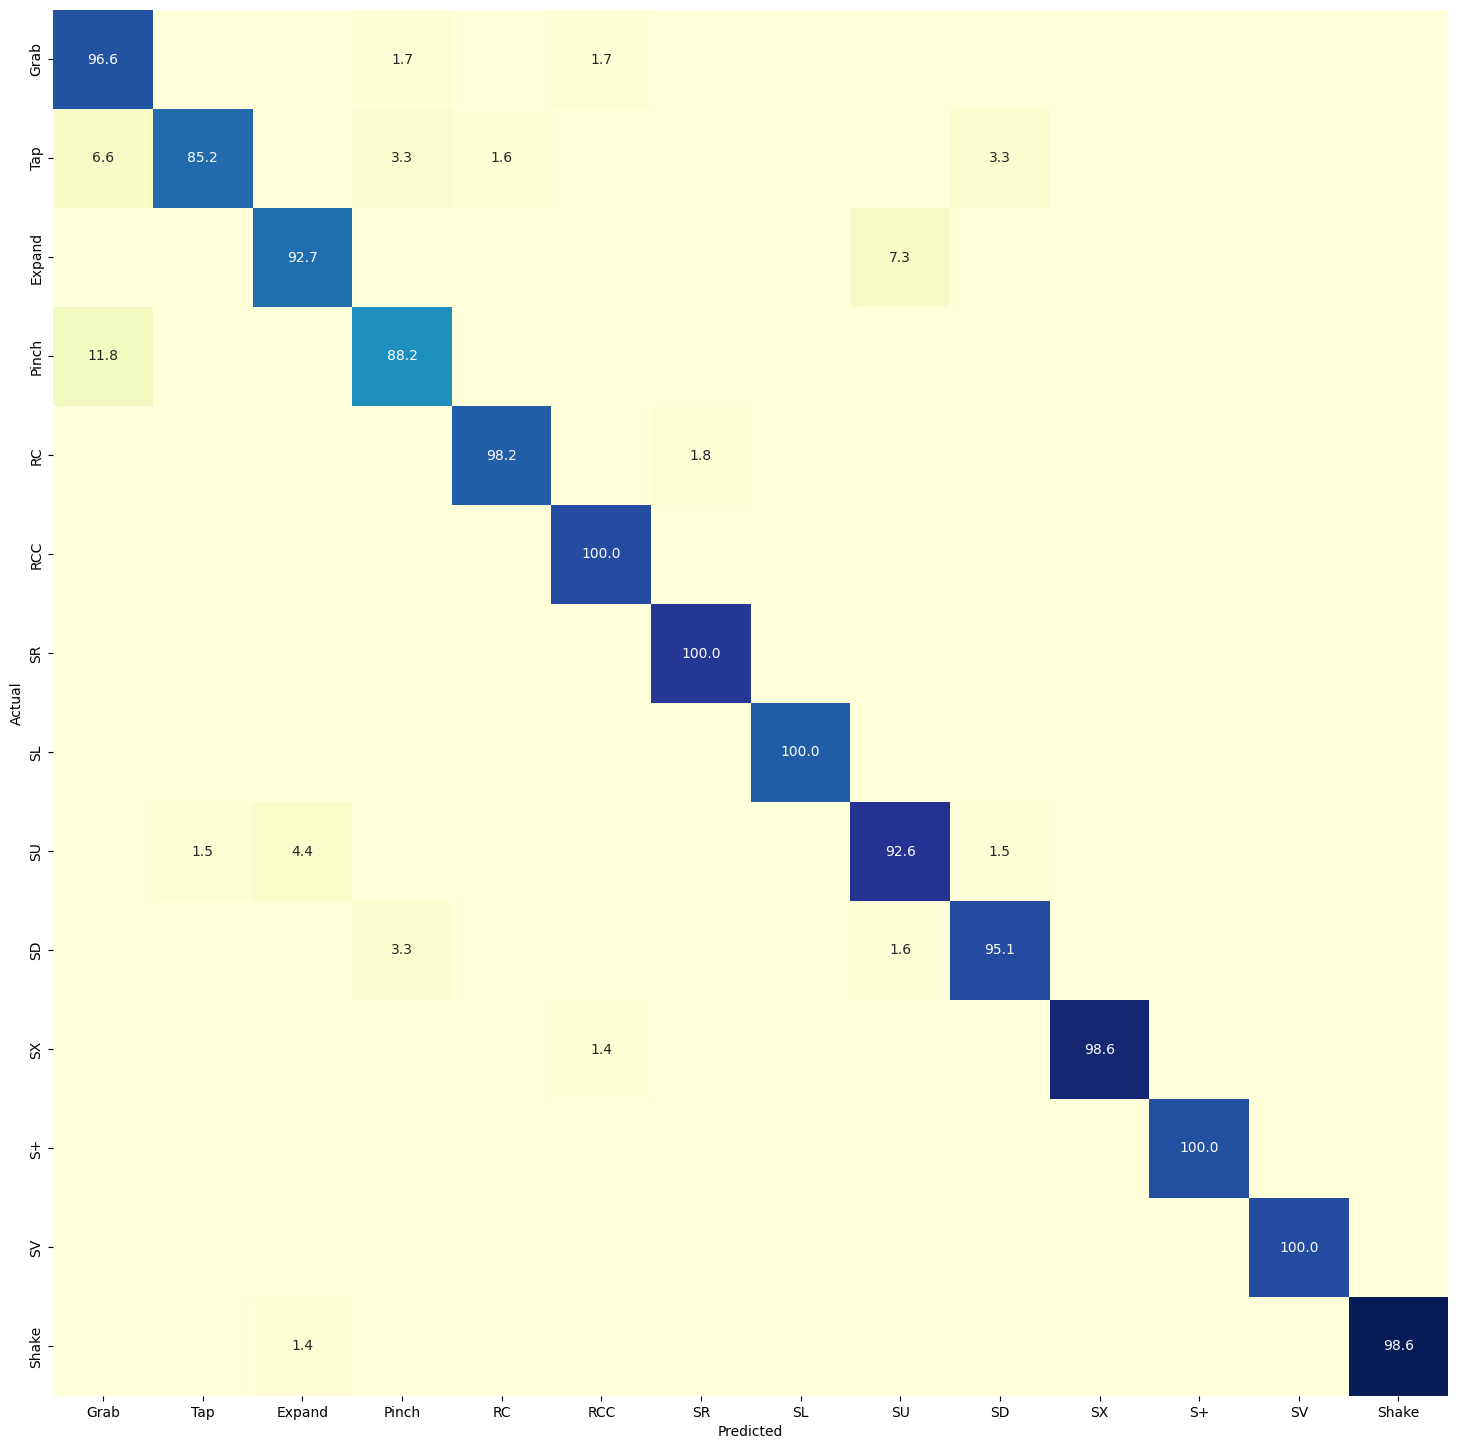

In [52]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_14_8.png', labels, ymap=None, figsize=(18,18))